<a href="https://colab.research.google.com/github/rory-smith/Lectures-on-inference-in-GW-astronomy/blob/master/GW_data_in_a_toy_universe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


In [ ]:
!pip install lalsuite

In [ ]:
!pip install latex

In [4]:
import lalsimulation as lalsim
import numpy as np
from scipy import stats
import pylab as plt
import lal
import pandas as pd
from scipy.special import logsumexp

In [203]:
data_frequency = 150 # In our universe, GW detectors only record data at 150Hz :)

###################################################################################################
### This function draws random noise with the right statistics ###
### In the frequency domain, LIGO/Virgo noise has mean zero and variance proportional
### to the noise PSD (real and imag parts are identially and independently distributed) 
###################################################################################################

def GW_detector_noise(N):


  deltaF = 1/4.
  noise_mean = 0
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(data_frequency) / (4*deltaF)

  noise_re = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))
  noise_imag = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))

  return noise_re + 1j*noise_imag

In [6]:
###################################################################################################
### This draws random samples of BBH masses. In our Universe, BBH masses are distributed according
### to a truncated normal distribution. You can change this to whatever you like ##################
###################################################################################################
def draw_mtotal(N):

  mtot_min = 30
  mtot_max = 100
  mtot_mean = 60
  mtot_var = 10
  a = (mtot_min-mtot_mean)/np.sqrt(mtot_var) # some annoying parameter for scipy function
  b = (mtot_max-mtot_mean)/np.sqrt(mtot_var)
  return stats.truncnorm.rvs(a, b, loc=mtot_mean, scale=np.sqrt(mtot_var),size=int(N))

In [ ]:
###################################################################################################
### These are the probability densities for the likelihood function, prior probability of the BBH
### masses, and the evidence. They are the mathematical functions that are used to construct the 
### posterior probabiltiy density of the BBH masses given some data ###############################
################################################################################################### 

## ln likelihood for the real part of the data #####################################################
###################################################################################################

def lnL_re(data,signal): 
  deltaF = 1/4.
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(data_frequency) / (4*deltaF)


  data_real = np.real(data)
  return stats.norm.logpdf(data_real, loc=signal.real, scale=np.sqrt(noise_var))

## ln likelihood for the imaginary part of the data ################################################
###################################################################################################

def lnL_im(data,signal):
  deltaF = 1/4.
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(data_frequency) / (4*deltaF)
  
  data_imag = np.imag(data)
  return stats.norm.logpdf(data_imag, loc=signal.imag, scale=np.sqrt(noise_var))

## ln likelihood for the full complex data, d= re(data) + im(data) #################################
###################################################################################################
def lnL(data,mtotal):
  signal = GW_signal(mtotal)[0] 
  ln_L_re = lnL_re(data,signal)
  ln_L_im = lnL_im(data,signal)

  return ln_L_re + ln_L_im

### ln prior probability density ###################################################################
####################################################################################################
def lnpi(mtotal):
  mtot_min = 30
  mtot_max = 100
  mtot_mean = 60
  mtot_var = 10
  a = (mtot_min-mtot_mean)/np.sqrt(mtot_var) # some annoying parameter for scipy function
  b = (mtot_max-mtot_mean)/np.sqrt(mtot_var)
  return stats.truncnorm.logpdf(mtotal,a, b, loc=mtot_mean, scale=np.sqrt(mtot_var))

### ln posterior probability density (un-normalized!) ##############################################
####################################################################################################
def ln_p_mtotal_given_data(mtotal, data):

  return lnpi(mtotal) + lnL(data, mtotal)
### ln evidence ####################################################################################
####################################################################################################
def ln_Z(ln_posterior,dx):

  return logsumexp(ln_posterior,b=dx)


In [7]:
# this is all bookkeepy stuff to allow us to evaluate a GW signal at GW frequency of 150Hz #####
f = np.array([data_frequency])
F = f#np.loadtxt("Freqs_long.txt")
F = lal.CreateREAL8Vector(len(F))
F.data[:] =  f
###############################################################################
def GW_signal(Mtotal):

  mass_ratio = 1 #all binaries in our universe contain equal-mass black holes
  Dist = 1e6*lal.lal.PC_SI #all binary black holes are located 0.1Gpc from our detector
  spin1x, spin1y, spin1z = 0, 0, 0 #black holes do not spin in our Universe
  spin2x, spin2y, spin2z = 0, 0, 0 #black holes do not spin in our Universe
  iota = 0 #all BBH obits are inclined such that their orbital plane is "face on"

  m1, m2 = Mtotal/(1+mass_ratio), Mtotal/(1+mass_ratio)

  m1 *= lal.lal.MSUN_SI #component mass into SI units
  m2 *= lal.lal.MSUN_SI
  WFdict = lal.CreateDict() #bookkeepy thing
  h = lalsim.SimIMRPhenomXPHMFrequencySequence(F, m1, m2, spin1x, \
            spin1y, spin1z, spin2x, spin2y, spin2z, Dist, iota, 0, 150, WFdict)
  
  signal = h[0].data.data + h[1].data.data #equal parts plus and cross polarization
  return signal

In [8]:
### Create some GW detector noise! ################################################################
###################################################################################################

noise_measurements = GW_detector_noise(5e6)

In [9]:
### Populate the Universe with BBH's (endow them with total masses) ###############################
###################################################################################################
BBH_masses = draw_mtotal(5e6)

In [10]:
### Now create the GW signals associated with our merging BBHs ####################################
###################################################################################################
signals = np.array([GW_signal(_m)[0] for _m in BBH_masses])

In [11]:
### Finally, add the signal to the noise to make the strain data (d=s+n)###########################
###################################################################################################

strain_data = signals + noise_measurements

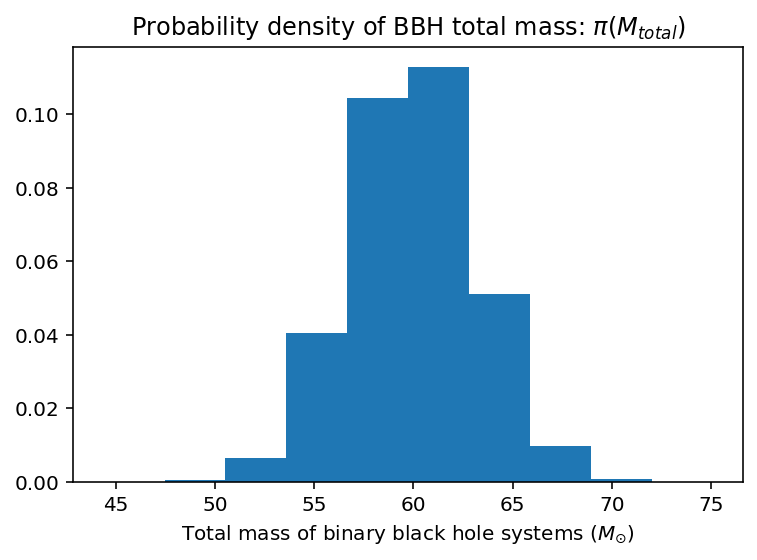

In [12]:
plt.hist(BBH_masses, density=True)
plt.xlabel(r"Total mass of binary black hole systems $(M_{\odot})$")
plt.title(r"Probability density of BBH total mass: $\pi(M_{total})$")
plt.show()

In [13]:
## bundle up our data, noise, masses into a pandas data frame 
_df = {'total mass':BBH_masses, 'strain_data':strain_data, 'noise':noise_measurements}
dataframe = pd.DataFrame(data=_df)

In [14]:
dataframe

,total mass,strain_data,noise
0,61.501551,-4.466780e-21+2.782726e-23j,7.055627e-24+4.689038e-24j
1,61.349297,-4.466470e-21+1.793634e-23j,-6.936680e-24-5.034796e-24j
2,64.327348,-4.750646e-21+2.808784e-23j,-4.280312e-24+1.595779e-24j
3,60.443511,-4.359818e-21+1.634503e-23j,1.541214e-23-5.655802e-24j
4,62.616503,-4.586126e-21+2.039844e-23j,-6.373418e-24-4.002199e-24j
...,...,...,...
4999995,59.128038,-4.254640e-21+1.834202e-23j,5.226551e-25-2.313525e-24j
4999996,60.695369,-4.393326e-21+2.638034e-23j,5.210798e-24+4.113605e-24j
4999997,60.577512,-4.380605e-21+1.988578e-23j,7.012561e-24-2.256163e-24j
4999998,62.303136,-4.544238e-21+8.836852e-24j,5.535561e-24-1.520172e-23j


In [213]:
mtotal_new = 59 
strain_data_new = GW_detector_noise(1) + GW_signal(mtotal_new)

In [214]:
precision = 24 #number of decimal places to round data

idx = np.where(np.around(strain_data,precision)==np.around(strain_data_new, precision))

In [215]:
# the part of the dataframe where the strain data equals the new data (to our set precision)
measurement_table = dataframe[dataframe.index.isin(idx[0])]

In [216]:
# this contains the total masses that produce strain data equal to what we just "measured"
# with this, we can estimate the probability of a the total mass given our newly measured data by counting  
measurement_table

,total mass,strain_data,noise
17887,59.004301,-4.240662e-21+2.210033e-23j,3.348275e-24+1.567894e-24j
26782,58.748936,-4.240726e-21+2.226274e-23j,-1.965603e-23+1.982661e-24j
58010,59.009827,-4.241281e-21+2.194666e-23j,3.226360e-24+1.408732e-24j
74123,58.855628,-4.240815e-21+2.194347e-23j,-1.017248e-23+1.558232e-24j
80219,58.896639,-4.241000e-21+2.167464e-23j,-6.673589e-24+1.248877e-24j
...,...,...,...
4914242,58.816716,-4.241434e-21+2.177025e-23j,-1.428475e-23+1.423407e-24j
4929785,59.008782,-4.241128e-21+2.228218e-23j,3.285212e-24+1.745296e-24j
4948678,58.908883,-4.240501e-21+2.230650e-23j,-5.074740e-24+1.868627e-24j
4955466,58.972571,-4.241314e-21+2.183689e-23j,-1.598205e-25+1.335929e-24j


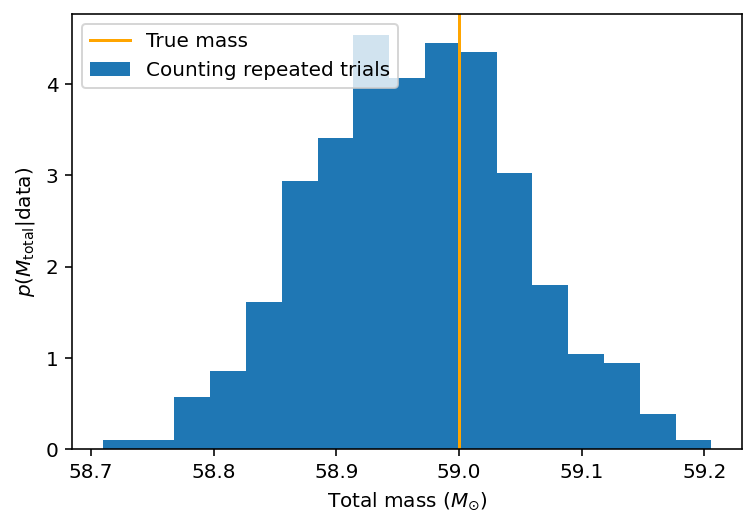

In [217]:
plt.hist(measurement_table['total mass'],bins='auto',density=True,label='Counting repeated trials')
plt.axvline(mtotal_new,c='orange',label='True mass')
plt.legend(loc=2)
plt.xlabel("Total mass ($M_{\odot})$")
plt.ylabel("$p(M_{\mathrm{total}}|$data)")
plt.ylim(0)
plt.show()

In [236]:
idx_mtotal_new  = np.where(np.abs(BBH_masses-61) < 0.01)

In [237]:
likelihood_table = dataframe[dataframe.index.isin(idx_mtotal_new[0])]

In [238]:
likelihood_table

,total mass,strain_data,noise
64,60.993124,-4.435485e-21+2.071870e-23j,-9.262210e-24-1.866195e-24j
701,61.001219,-4.430101e-21+2.516668e-23j,-3.123134e-24+2.573078e-24j
1449,61.007680,-4.430328e-21+1.880413e-23j,-2.747279e-24-3.796428e-24j
2129,60.997929,-4.432856e-21+1.528529e-23j,-6.185034e-24-7.304768e-24j
3178,61.003997,-4.427132e-21+1.400896e-23j,1.046989e-25-8.587628e-24j
...,...,...,...
4997339,61.009784,-4.430036e-21+2.098565e-23j,-2.259520e-24-1.617164e-24j
4998031,61.007528,-4.444472e-21+1.974802e-23j,-1.690604e-23-2.852373e-24j
4998546,60.991571,-4.440449e-21+2.592094e-23j,-1.437049e-23+3.337716e-24j
4999267,61.003444,-4.433680e-21+2.820931e-23j,-6.494868e-24+5.613320e-24j


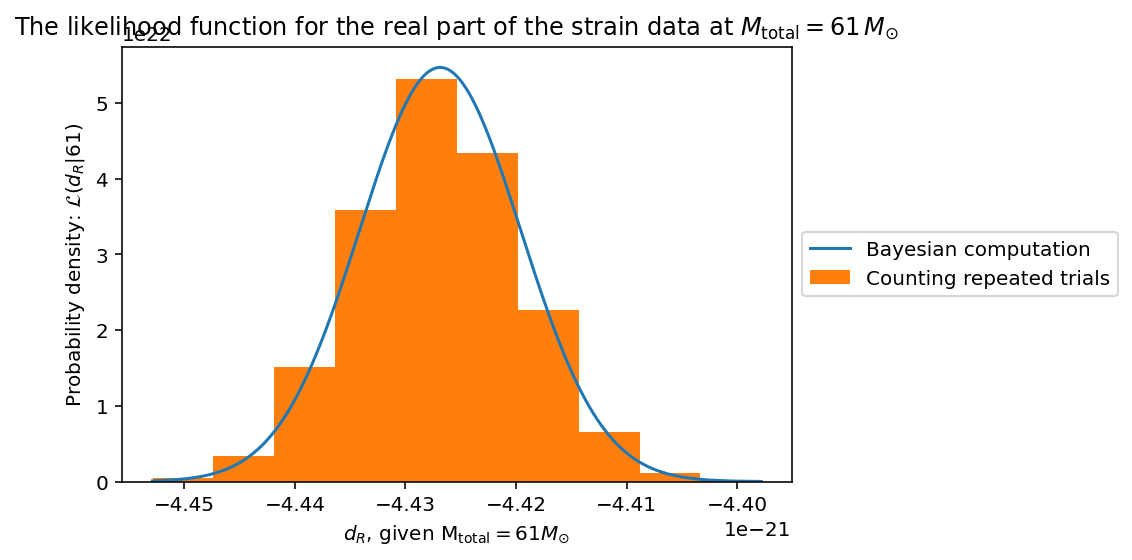

In [251]:
signal = GW_signal(61)[0] 

likelihoods=np.array([lnL_re(_s,signal) for _s in np.sort(np.real(likelihood_table['strain_data']))])

plt.plot(np.sort(np.real(likelihood_table['strain_data'])), np.exp(likelihoods),label='Bayesian computation')
plt.hist(np.real(likelihood_table['strain_data']),density=True,label='Counting repeated trials')
plt.xlabel("$d_R$, given M$_{\mathrm{total}} = 61M_{\odot}$")
plt.ylabel("Probability density: $\mathcal{L}(d_R|61)$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("The likelihood function for the real part of the strain data at $M_{\mathrm{total}}=61\,M_{\odot}$")
plt.show()

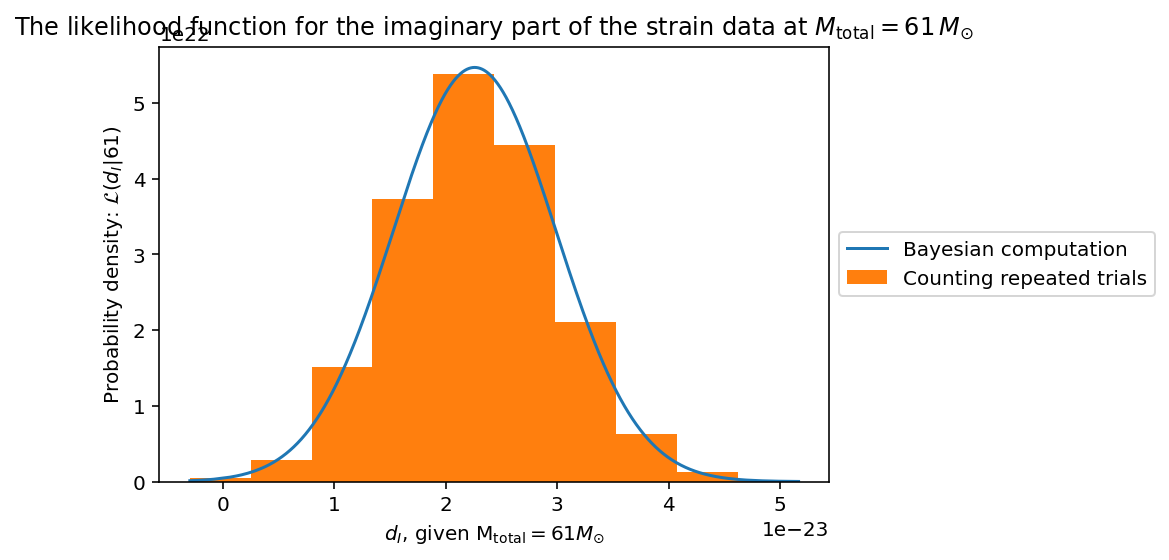

In [262]:
signal = GW_signal(61)[0] 

likelihoods=np.array([lnL_im(1j*_s,signal) for _s in np.sort(np.imag(likelihood_table['strain_data']))])

plt.plot(np.sort(np.imag(likelihood_table['strain_data'])), np.exp(likelihoods),label='Bayesian computation')
plt.hist(np.imag(likelihood_table['strain_data']),density=True,label='Counting repeated trials')
plt.xlabel("$d_I$, given M$_{\mathrm{total}} = 61M_{\odot}$")
plt.ylabel("Probability density: $\mathcal{L}(d_I|61)$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("The likelihood function for the imaginary part of the strain data at $M_{\mathrm{total}}=61\,M_{\odot}$")
plt.show()

In [222]:
# Let's compute the posterior probability density for a selection of masses 
# We should get the same shape as the histogram and the precise numerical values for the probability density
m_tot_list = np.linspace(58.5,59.5,1000)

ln_posterior = np.array([ln_p_mtotal_given_data(_m,strain_data_new) for _m in m_tot_list])

ln_evidence = ln_Z(ln_posterior,(m_tot_list[1]-m_tot_list[0]))

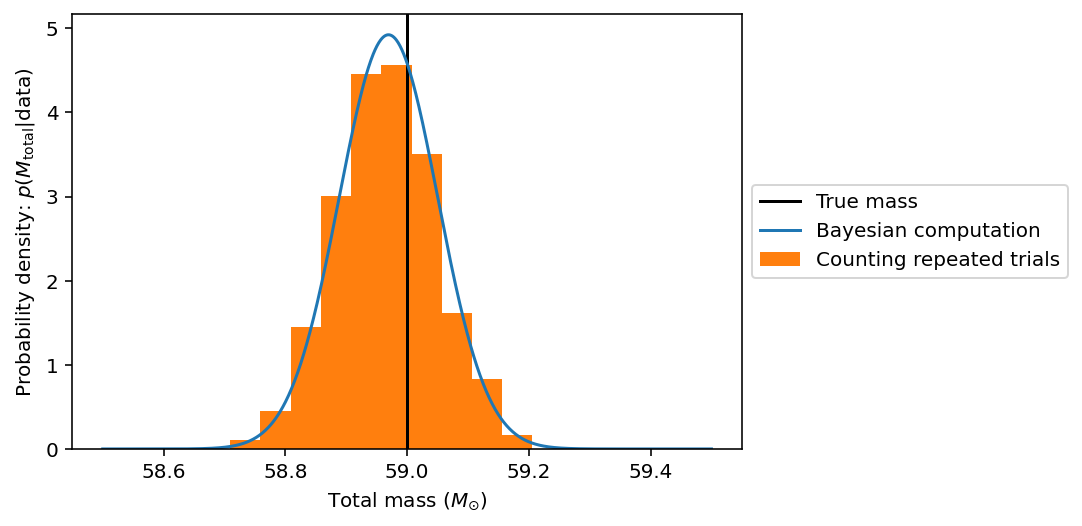

In [254]:
plt.axvline(mtotal_new,c='black',label='True mass')
plt.plot(m_tot_list, np.exp(ln_posterior)/np.exp(ln_evidence),label='Bayesian computation')
plt.hist(measurement_table['total mass'],density=True,label='Counting repeated trials')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Total mass ($M_{\odot})$")
plt.ylabel("Probability density: $p(M_{\mathrm{total}}|$data)")
plt.ylim(0)
plt.show()

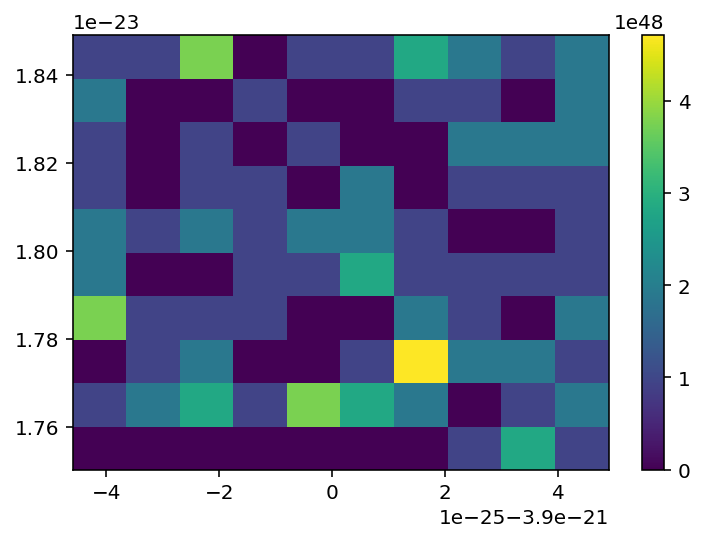

In [88]:
plt.hist2d(np.real(measurement_table['strain_data']), np.imag(measurement_table['strain_data']),density=True)
plt.colorbar()
plt.show()
#plt.axvline(strain_data_new,c='orange')
#plt.axhline(np.exp(ln_evidence))

In [82]:
np.exp(ln_evidence)

2.3805388981944163e+43

In [89]:
_L=np.array([lnL(strain_data_new,_m) for _m in m_tot_list])

In [90]:
_L

array([[96.65576745],
       [96.65898802],
       [96.66220818],
       ...,
       [96.4445882 ],
       [96.4412864 ],
       [96.43798411]])

In [67]:
stats.norm.logpdf(1+1j)

(-0.9189385332046727-1j)

In [68]:
stats.norm.logpdf(1) + stats.norm.logpdf(1)

-2.8378770664093453

In [185]:
_L=np.array([lnL(_s,mtotal_new) for _s in likelihood_table['strain_data']])


In [260]:
np.sort(np.imag(likelihood_table['strain_data']))

array([-2.97679568e-24, -2.92170163e-24, -2.06493245e-24, ...,
        4.99192763e-23,  5.14708573e-23,  5.16771774e-23])